# SPEED LIMIT EXTRACTION

In [1]:
import pandas as pd # To structure and manipulated data in a DataFrame format
import geopandas as gpd # To work with spatial data in a DataFrame
from geopandas import GeoDataFrame # To create a GeoDataFrame from a DataFrame
import numpy as np
from shapely.geometry import shape, Point, LineString # To create line geometries that can be used in a GeoDataFrame

import matplotlib.pyplot as plt
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline


## INPUT DATA

In [124]:
df= pd.read_csv('input/improved_smoothing.csv')
df.head()

,vehicle,level_1,datetime,speed,y,x,heading,vehicleType,time_interval,distance,heading_interval,trip
0,15C01678,0,2018-04-24 17:56:31,8.0,106.681912,10.765504,0.0,500,0,32.364445,0.000000,0
1,15C01678,1,2018-04-24 17:56:42,13.0,106.682047,10.765733,1.0,500,11,33.819979,14.889869,0
2,15C01678,2,2018-04-24 17:56:50,18.0,106.682280,10.765950,2.0,500,8,33.213130,1.598900,0
3,15C01678,3,2018-04-24 17:56:56,20.0,106.682484,10.766184,3.0,500,6,35.094524,0.465903,0
4,15C01678,4,2018-04-24 17:57:02,22.0,106.682693,10.766422,4.0,500,6,32.605395,2.429086,0


**Chuyển sang dạng GeoDataframe:**

In [125]:
geometry = [Point(xy) for xy in zip(df.x, df.y)]
# gdf = df.drop(['y', 'x'], axis=1)
# gdf = gdf.sort_values('datetime', ascending = True)
gdf = GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

gdf['datetime'] = pd.to_datetime(gdf['datetime'])
gdf = gdf.sort_values(['vehicle', 'datetime'], ascending=[True, True])
gdf.reset_index(drop=True, inplace=True)
# show gdf data
gdf.count()

vehicle             97942
level_1             97942
datetime            97942
speed               97942
y                   97942
x                   97942
heading             97942
vehicleType         97942
time_interval       97942
distance            97942
heading_interval    97942
trip                97942
geometry            97942
dtype: int64

## Ý tưởng cơ bản để rút trích đặc trưng tốc độ giới hạn

Tài liệu nghiên cứu: <a href="https://drive.google.com/file/d/11YQy3dha-8q8LVxZuwwXcyKNcumtYxWh/view">Automatic Update of Road Attributes by Mining GPS Tracks (page 8)</a>

<b>Tốc độ giới hạn được chia làm 3 lớp: low, medium và high.</b>

Trong đó tốc độ của các lớp (chia theo luật giao thông VN)

| Id | Level    | Value      |
|--- |----------| -----------|
| 01 | Low      |40, 50, 60  |
| 02 | Medium   | 70, 80, 90 |
| 03 | High     | 100, 120   |

<img src="img/speed_limit_level.png" width="500"> <br> <i>Minh họa chia lớp tốc độ giới hạn</i>

Ý tưởng cơ bản là xét từng đoạn đường, lấy vận tốc trung bình để có được tốc độ giới hạn. Nhưng có rất nhiều điểm có vận tốc thấp, vận tốc thay đổi đột ngột làm ảnh hưởng đến quá trình tính toán: dừng đèn đỏ, tắc đường, gặp phải chướng ngại vật,...

Để lọc các điểm trên, thay vì dùng đại lượng gia tốc, tác giả đề xuất sử dụng <b>velocity change rate (VCR)</b> tạm dịch <b>tỉ lệ thay đổi vận tốc</b> để tính <b>VCR</b> của 2 điểm liên tiếp nhau. Ý nghĩa của <b>VCR</b> là các điểm có giá trị <b>VCR</b> càng gần 0 thì vật di chuyển ổn định, càng xa 0 thì vật di chuyển bất ổn, thay đổi vận tốc đột ngột.

<b>Công thức VCR</b>

<img src="img/vcr_formula.png" width="600"> <br> Trong đó $$v2, v1$$ là vận tốc tức thời của 2 điểm liên tiếp nhau trên 1 hành trình

Từ đó chọn ra những điểm có <b>VCR</b> trong khoảng <b>range</b> = [-0,15:0,15] để chọn làm điểm đại diện dùng cho tính toán. Theo như tác giả thống kê thì các điểm trong khoảng <b>range</b> cho ra kết quả tốt. (<b>range</b> sẽ được thay đổi cho phù hợp với dữ liệu của giao thông VN).

Sau khi lọc các điểm không hợp lệ, giá trị vận tốc trung bình có thể được xem như là tốc độ giới hạn của đoạn đường đó.

<img src="img/speed_limit_output.png" width="500">

## Mã giả & Cài đặt thuật toán

Bên dưới là mã giả cho thuật toán rút trích đặc trưng tốc độ giới hạn. Chỉ tính toán trên các đoạn có ít nhất 50 mẫu

<img src="img/speed_limit_algorithm.png" width="800">

### Chọn mẫu test

In [232]:
group = gdf.groupby('trip')
group.mean()[group.speed.mean() > 40]

,level_1,speed,y,x,heading,vehicleType,time_interval,distance,heading_interval
trip,,,,,,,,,
86,1.5,45.500000,106.685756,10.788072,1.5,600.0,17.500000,206.139318,2.057710
103,1.0,42.666667,106.696150,10.780215,1.0,300.0,300.666667,170.519443,47.484193
157,1.0,42.000000,106.690288,10.786211,1.0,700.0,43.333333,188.184438,1.143009
160,1.0,46.333333,106.666648,10.767474,1.0,700.0,30.000000,219.280574,0.414363
205,3.0,46.571429,106.685159,10.788672,3.0,300.0,10.142857,135.854525,15.662342
...,...,...,...,...,...,...,...,...,...
14608,2.0,40.800000,106.684970,10.768922,2.0,700.0,16.000000,129.909895,1.110681
14641,3.0,42.000000,106.676930,10.773578,3.0,300.0,17.142857,152.355226,12.037392
14656,1.0,44.000000,106.696492,10.789303,1.0,0.0,13.000000,128.146678,0.875925


In [233]:
# gdftest = gdf[gdf.trip == 236]
gdftest = gdf[gdf.trip == 205]

### Hàm lọc các điểm không hợp lệ

In [234]:
'''
Mô tả: VRC_filter() lọc và bỏ các điểm có VCR nằm ngoài đoạn [0 : threshold] của 1 trip
input:
    gdf: geodataframe, 1 trip
    threshold: integer, default 0.15
output:
    trip_filtered: geodataframe
'''
def vcr_filter(gdf, threshold=0.1):
    filter = []
    
    counter = 0
    # init v0 for first calculation vcrate = (v_(i+1) - v_i)/v_i
    v0 = gdf.iloc[0].speed
    for idx, row in gdf.iterrows():
        v1 = row.speed
        vcrate = abs(v1 - v0) / v0
        # drop point has lower velocity if vcr out of range = [0 : threshold]
        if vcrate > threshold:
            if v0 < v1: # drop v0
                filter.append(gdftest.index.values[counter-1])
            elif v0 >= v1:
                filter.append(idx)
        # update counter
        counter = counter + 1
        # update v0
        v0 = v1
    print(f'speed: {gdf.speed}')
    print (f'filter: {list(set(filter))}')
    print(f'drop numbers: {np.count_nonzero(list(set(filter)))}')
    return list(set(filter))
# test

In [235]:
# get filter row array
gdf_filter = vcr_filter(gdftest)

speed: 1464    28.0
1465    42.0
1466    43.0
1467    47.0
1468    59.0
1469    57.0
1470    50.0
Name: speed, dtype: float64
filter: [1464, 1467, 1470]
drop numbers: 3


In [236]:
gdf_dropped = gdftest.drop(gdf_filter)

### Dùng <b>VCR</b> lọc các điểm không hợp lệ 

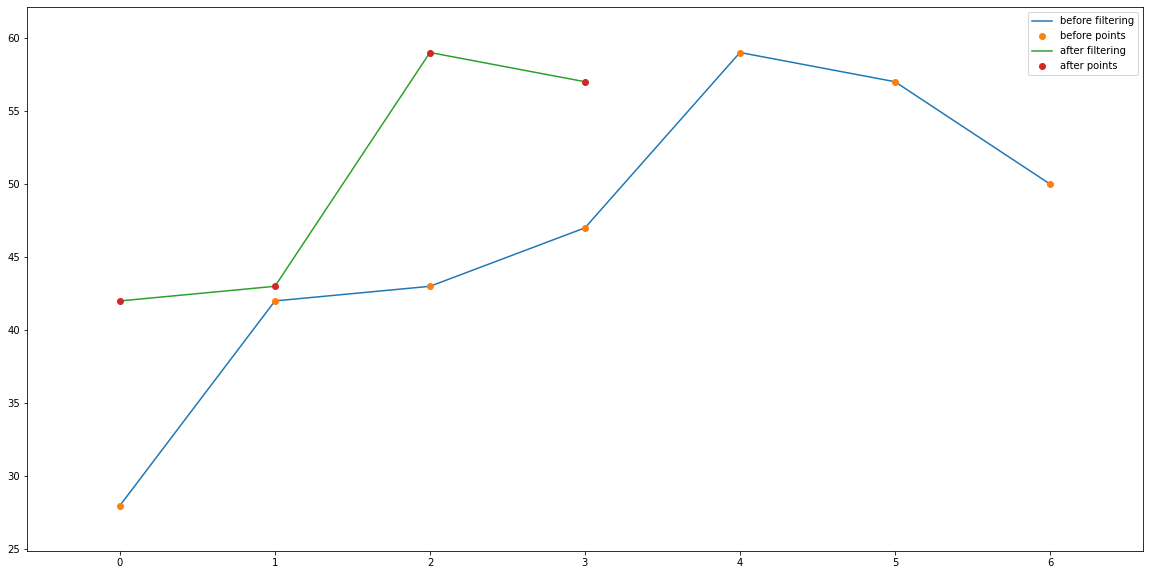

In [237]:
x = np.arange(gdftest.speed.count())
y = gdftest.speed.ravel()
y2 = gdf_dropped.speed.ravel()
plt.figure(figsize=(20,10))
# plot before
plt.plot(x, y)
plt.plot(x, y, 'o')
# plot after
x2 = np.arange(gdf_dropped.speed.count())
plt.plot(x2, y2)
plt.plot(x2, y2, 'o')
plt.legend(['before filtering', 'before points', 'after filtering', 'after points'])

### Tốc độ trung bình trước và sau khi lọc bỏ bớt điểm

Trước

In [238]:
gdftest.speed.mean()

46.57142857142857

Sau

In [239]:
gdf_dropped.speed.mean()

50.25

## Trực quan hóa dữ liệu lên bản đồ

In [240]:
import folium

### helper functions: visualize into folium map

In [241]:

''' get_vehicles() params:
input:
    gdf: geodataframe
output:
    vehicles: list vehicle id
'''
def get_trajecs(gdf):
    # get list trajecs
    trajecs = gdf.drop_duplicates(subset='trip')['trip']
    trajecs = np.array(trajecs, dtype=object)
    
    return trajecs

In [242]:
colors = [
    'red',
    'yellow',
    'blue',
    'lightred',
    'orange',
    'green',
    'lightgreen',
    'purple',
    'pink']

def add_point(mapobj, gdf, colors):
    #Nạp x,y từ dataframe vào list coords
    coords = list(zip(gdf["geometry"].x, gdf["geometry"].y))
    #Hiển thị trên mapobj
    for coord in coords:
        folium.CircleMarker(location = coord,
                            radius = 1.5, 
                            fill = True,
                            fill_opacity = 0.75,
                            color = colors,
                            weight = 0.01).add_to(mapobj)
           
def add_lines(mapobj, gdf, color):
    coords = list(zip(gdf["geometry"].x, gdf["geometry"].y))
    folium.PolyLine(coords, color=color, weight=1, opacity=1).add_to(mapobj)
       
    
'''
Hàm hiển thị map.
Tùy chọn:
- mapobj: bản đồ nền
- gdf: geodataframe
- start: lộ trình bắt đầu
- end: lộ trình kết thúc
- mask_type: dạng đường (1) và dạng điểm (0)
'''
def show_n_route(mapobj, gdf, mask_type):
    # Khởi tạo bản đồ mapobj
    f = folium.Figure(height = 600)
    mapobj.add_to(f)

    # Get list trajecs id
    trajecs = get_trajecs(gdf)
    # Show every single trajec
    for idx,id in enumerate(trajecs):
        # get sub trajec
        subgdf = gdf[gdf['trip'] == id]

        if mask_type == 0:
            add_point(mapobj, subgdf, colors[idx % len(colors)])
        else:
            add_lines(mapobj, subgdf, colors[idx % len(colors)])
  
    return mapobj

### BEFORE APPLYING RDP ALGORITHM

In [243]:
# map
mapobj1 = folium.Map([10.783284, 106.682347], zoom_start = 15, tiles='Cartodb dark_matter')

# show lines fisrt
show_n_route(mapobj1, gdftest, 1)
# show points 
show_n_route(mapobj1, gdftest, 0)


### AFTER

In [244]:
# map
mapobj2 = folium.Map([10.783284, 106.682347], zoom_start = 15, tiles='Cartodb dark_matter')

# show lines fisrt
show_n_route(mapobj2, gdf_dropped, 1)
# show points 
show_n_route(mapobj2, gdf_dropped, 0)


Saving output